# Netflix Dataset Baseline Modeling

# DO NOT RUN
Takes several hours to complete.

In [1]:
import sqlite3
import pathlib
from contextlib import closing

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

Constants
=================

These constants are related to the logistics side of the training:
 + ``DB_PATH`` is the location of the SQLite database containing all relevant data
 + ``TRAINING_DIR`` is the location of all training checkpoints, summaries, and debug info if any.
 + ``BATCH_SIZE`` is the number of rating records retrieved at once for a training step
 + ``NUM_MODEL_GROUPS`` is the number of randomly assigned groups that the ratings belong to
 + ``NUM_INPUT_JOBS`` is the number of threads that will read from the database and pipe to the input queue
 + ``TEST_PERCENTAGE`` is the percentage of all ratings that will be used for testing
 + ``VALIDATION_PERCENTAGE`` is the percentage of the testing ratings that will be used for validation

In [2]:
# data related constants

DB_PATH = pathlib.Path('/') / 'data' / 'declanvk' / 'netflix_prize.sqlite'
TRAINING_DIR = pathlib.Path('/') / 'data' / 'declanvk' / 'training_log'
BATCH_SIZE = 1000
NUM_MODEL_GROUPS = 1000000
NUM_INPUT_JOBS = 2

TEST_PERCENTAGE = 0.3
VALIDATION_PERCENTAGE = 0.5

MODEL_GROUP_ID_BASE_QUERY = """
SELECT
  rating.item_id AS ItemID,
  rating.customer_id AS CustomerID,
  rating.value AS Rating,
  rating.day AS Day,
  freq AS Freq
FROM rating
  INNER JOIN customer_time_freq
    ON (
    customer_time_freq.customer_id = rating.customer_id AND
    customer_time_freq.day = rating.day)
WHERE model_group_id IN ({});
"""

COLUMN_TYPES = [np.int32, np.int32, np.float32, np.int32, np.int32]
TF_COLUMN_TYPES = [tf.int32, tf.int32, tf.float32, tf.int32, tf.int32]

Hyperparameters
================

These constants are used to control the model and how it learns.
 + ``STARTER_LEARNING_RATE`` is the initial learning rate of the stochastic gradient descent prior to decay.
 + ``LEARNING_RATE_DECAY`` is the amount that the learning rate is decreased by every decrease.
 + ``TOTAL_STEPS`` is the total number of iterations of SGD.
 + ``NUM_STAIRS`` is number of decreases that the learning rate will undergo.
 + ``ITEM_TIME_BINS`` and ``CUSTOMER_DRIFT_RATE`` are used to control features of the model that might be in use.

In [3]:
# Constants associated with learning

STARTER_LEARNING_RATE = 0.0015
LEARNING_DECAY_RATE = 2 / 3
TOTAL_STEPS = 50000
NUM_STAIRS = 10

ITEM_TIME_BINS = 30

CUSTOMER_DRIFT_RATE = 0.4

More Constants
===============

These constants are dependent on the data in the database. The variables names speak for themsevles, but mean_days is the mean day of rating for each customer. The CustomerID corresponds to the index in the array.

In [4]:
# Query database for constants

with sqlite3.connect(str(DB_PATH)) as connection, closing(connection.cursor()) as curs:
    curs.execute('SELECT count(*) FROM item')
    num_items, = curs.fetchone()
    curs.execute('SELECT count(*) FROM rating')
    num_ratings, = curs.fetchone()
    curs.execute('SELECT count(*) FROM customer')
    num_customers, = curs.fetchone()
    curs.execute('SELECT avg(value) FROM rating')
    avg_rating, = curs.fetchone()
    curs.execute('SELECT mean_day FROM customer ORDER BY customer_id ASC')
    mean_days = list(map(lambda row: row[0], curs.fetchall()))
    curs.execute('SELECT min(day), max(day) FROM rating')
    min_day, max_day = curs.fetchone()
    curs.execute('SELECT min(freq), max(freq) FROM customer_time_freq')
    min_freq, max_freq = curs.fetchone()
    min_log_freq, max_log_freq = list(map(lambda x: int(np.floor(np.log(x))), [min_freq, max_freq]))

Parameters
===========

The parameters are the main output of training the model, these will be used to predict future ratings and suggest movies to customers.
 + ``item_baseline`` is the base effect only dependent on the item
 + ``customer_baseline`` is the base effect only dependent on the customer
 + ``item_time_bin`` captures time based effects after the reducing to a smaller number of bins only for items
 + ``customer_drift`` captures change in customer rating preferences over time

In [5]:
# Define variables to train
with tf.name_scope('variables'):
    item_baseline = tf.Variable(tf.zeros([num_items]), dtype=tf.float32,\
                                name="item_baseline")
    item_time_bin = tf.Variable(tf.zeros([num_items, ITEM_TIME_BINS + 1]), dtype=tf.float32,\
                                name='item_time_dependent_constant')
    item_log_freq_base = tf.Variable(tf.zeros([num_items, (max_log_freq - min_log_freq) + 1]), dtype=tf.float32,\
                                    name='item_log_freq_baseline')
    customer_baseline = tf.Variable(tf.zeros([num_customers]), dtype=tf.float32,\
                                    name="customer_baseline")
    customer_drift = tf.Variable(tf.zeros([num_customers]), dtype=tf.float32,\
                                 name='customer_temporal_drift')
    customer_multiplier = tf.Variable(tf.ones([num_customers]), dtype=tf.float32,\
                                     name='customer_baseline_multiplier')
    
VARIABLES = [item_baseline, item_time_bin, item_log_freq_base, customer_baseline, customer_drift, customer_multiplier]
VAR_NAMES = ['item_baseline', 'item_time_binned_baseline', 'item_log_frequency_baseline', 'customer_baseline',\
             'customer_drift', 'customer_multiplier']

Helper Functions
===========================

These functions either retrieve data or create Tensorflow nodes that follow a common pattern.
 + ``fetch_model_group`` performs all database queries, both within the tensorflow framework and outside it for reading complete test data out.
 + ``predict_ratings`` takes equal length Tensors containing the all the data needed to predict ratings and returns a Tensor containing predictions for each rating in the parameters. The equation for the baseline rating prediction is:
$$
b_{ui} = \mu + b_u + \alpha_u \cdot d{ev}_u(t_{ui}) + \left ( b_i + b_{i, Bin(t_{ui})} \right ) \cdot c_u + b_{i,f_{ui}}
$$ This function comes from the the paper published by the Netflix Prize winners, with some modification. Their learning process allowed differing learning rates for different variables, which I was unable to replicate. They also included some other time based constants which I removed due to the lack of support for SparseTensor variables in Tensorflow.
 + ``create_error_nodes`` takes the expected and predicted ratings and produces various error statistics from those

In [6]:
# func defs for data and training

def fetch_model_group(all_group_ids, input_size=None, output_size=BATCH_SIZE):
    """
    Load rating groups with given ids, if size specified only take 
    a random selection of group ids of size size
    """
    input_size = input_size if input_size is not None else BATCH_SIZE // 10
    group_ids = np.random.choice(all_group_ids, size=input_size, replace=False)
    query = MODEL_GROUP_ID_BASE_QUERY.format(",".join(map(str, group_ids)))
    
    with sqlite3.connect(str(DB_PATH)) as connection:
        data = pd.read_sql(query, connection)
        data = data.ix[data.index < output_size]
        convert_pair = lambda pair: data[pair[1]].as_matrix().astype(COLUMN_TYPES[pair[0]])
        return list(map(convert_pair, enumerate(data)))
    
def predict_ratings(item_idx, customer_idx, day, frequency):
    """
    Return Tensorflow object that is the rating prediction for the given item, customer, and day
    All tensors need to be the same size
    """
    with tf.name_scope('prediction'):
        with tf.name_scope('item_term'):
            with tf.name_scope('time_dependent_constant'):
                binned_day = ITEM_TIME_BINS * (day - min_day) / (max_day - min_day)
                binned_day = tf.cast(binned_day, tf.int32)
                time_bin_idx = tf.stack([item_idx, binned_day], axis=1)
                item_time_bin_subset = tf.gather_nd(item_time_bin, time_bin_idx)
            with tf.name_scope('time_frequency_constant'):
                floor_log_freq = tf.cast(tf.floor(tf.log(tf.cast(frequency, tf.float32))), tf.int32)
                item_freq_idx = tf.stack([item_idx, floor_log_freq], axis=1)
                item_freq_const_subset = tf.gather_nd(item_log_freq_base, item_freq_idx)
            item_baseline_subset = tf.gather(item_baseline, item_idx)
            item_term = item_baseline_subset + item_time_bin_subset
        with tf.name_scope('customer_term'):
            with tf.name_scope('customer_item_multiplier'):
                customer_mult_subset = tf.gather(customer_multiplier, customer_idx)
                customer_mult = customer_mult_subset
            with tf.name_scope('customer_deviation'):
                time_diff = tf.subtract(tf.to_float(day), tf.gather(customer_mean_days, customer_idx))
                diff_sign = tf.sign(time_diff)
                diff_dev = diff_sign * tf.pow(tf.abs(time_diff), time_drift_rate)
                customer_deviation = tf.gather(customer_drift, customer_idx) * diff_dev
            customer_baseline_subset = tf.gather(customer_baseline, customer_idx)
            customer_term = customer_baseline_subset + customer_deviation
        return overall_average_rating + customer_term + (item_term * customer_mult) + item_freq_const_subset

def create_error_nodes(expected, predicted):
    """
    Create error tensor objects for expected and predicted ratings
    """
    with tf.name_scope('error_components'):
        residual_ss = tf.reduce_mean(tf.square(tf.subtract(expected, predicted)))
        total_ss = tf.reduce_sum(tf.square(tf.subtract(expected, tf.reduce_mean(expected))))
        
    rmse = tf.sqrt(residual_ss, name='rmse')
    with tf.name_scope('r_squared'):
        r_squared = tf.subtract(1.0, tf.div(residual_ss, total_ss))
    
    return residual_ss, total_ss, rmse, r_squared

Test Train Split
===============

Based on previous described constants, splitting the data into train and test, then from test splitting into test and validation. Train will be randomly sampled to provide data for stochastic gradient descent, while validation will provide an independent estimation of the general error rate at every step in the training processs. The test dataset will be used once at the end to reinforce the the validation error rate. The validation test split might not be entirely necessary in this instance.

In [7]:
# Split groups ids into training, test, and validation

raw_train_ids, raw_test_ids = train_test_split(np.arange(NUM_MODEL_GROUPS), test_size=TEST_PERCENTAGE)

raw_test_ids, raw_validation_ids = train_test_split(raw_test_ids, test_size=VALIDATION_PERCENTAGE)

Tensorflow Constants
=================

Translating the previous described constants into something Tensorflow can understand involves wrapping them in ``tf.constant`` calls. This force explicit data types and names for each constant in the Tensorflow context.

In [8]:
# Define constant, mostly ids
with tf.name_scope('constants'):
    overall_average_rating = tf.constant(avg_rating, tf.float32, name="overall_average_rating")
    customer_mean_days = tf.constant(mean_days, tf.float32, name='customer_mean_days')
    
    time_drift_rate = tf.constant(CUSTOMER_DRIFT_RATE, tf.float32, name='customer_rating_drift_rate')

    train_ids = tf.constant(raw_train_ids, tf.int32, name="training_ids")
    test_ids = tf.constant(raw_test_ids, tf.int32, name="test_ids")
    val_ids = tf.constant(raw_validation_ids, tf.int32, name="validation_ids")

Global Step
==================

The global step variable controls the learning rate decay, and is used to identify how far the training process is from completion.

In [9]:
# The global step controls the learning rate decay

global_step = tf.Variable(0, trainable=False, name='global_step')

Data Input
================

Data is funneled from two threads into a randomly shuffled queue that makes certain the sampling from the dataset is random. These operations make more sense if you consider them in the context of building a computational graph, the final ``input_quue.dequeue`` call is only creating new nodes in the graph.

In [10]:
# Inputs are pulled in batch size from the database then put in a random queue
# The enqueue op can be passed into multiple threads to parallize this operation and prevent bottleneck
with tf.name_scope('input'):
    input_queue = tf.RandomShuffleQueue(capacity=NUM_INPUT_JOBS ** 2 + 4, min_after_dequeue=NUM_INPUT_JOBS,\
                                        dtypes=TF_COLUMN_TYPES, \
                                        shapes=[(BATCH_SIZE,)] * len(TF_COLUMN_TYPES), \
                                        name="batch_queue")
    training_data = tf.py_func(func=fetch_model_group, inp=[train_ids], Tout=TF_COLUMN_TYPES,\
                               name="database_fetch")
    enqueue_op = input_queue.enqueue(training_data, name="enqueue_batch")
    
    train_item_indices, train_customer_indices, train_ratings, train_days, train_freqs = \
        input_queue.dequeue(name="get_batch")

Regularization
===================

Regularization of the parameters is needed to prevent overfitting and penalize their magnitude. Different penalties are applied to each variable by multiply a rate by the $L_2$ norm of the variable. The sum of regularizations is then added to the least squares minimization that is the objective and the total function is used as the loss function for the optimizer.

In [11]:
REG_RATES = {
    item_baseline: 0.01,
    item_time_bin: 500,
    item_log_freq_base: 0.1,
    customer_baseline: 0.01,
    customer_drift: 500,
    customer_multiplier: 0.1,
}

In [12]:
# Model loss formulation for training data
with tf.name_scope('loss'):
    with tf.name_scope('training'):
        train_prediction = predict_ratings(train_item_indices, train_customer_indices, train_days, train_freqs)
    to_minimize = tf.subtract(train_ratings, train_prediction)
    
    with tf.name_scope('least_squares'):
        least_squares = tf.reduce_sum(tf.pow(to_minimize, 2))
    with tf.name_scope('regularization'):
        item_base_reg = REG_RATES[item_baseline] * tf.nn.l2_loss(item_baseline)
        item_time_reg = REG_RATES[item_time_bin] * tf.nn.l2_loss(item_time_bin)
        item_freq_reg = REG_RATES[item_log_freq_base] * tf.nn.l2_loss(item_log_freq_base)
        cust_base_reg = REG_RATES[customer_baseline] * tf.nn.l2_loss(customer_baseline)
        cust_drif_reg = REG_RATES[customer_drift] * tf.nn.l2_loss(customer_drift)
        cust_mult_reg = REG_RATES[customer_multiplier] * tf.nn.l2_loss(customer_multiplier - 1)
        regularization = item_base_reg + item_time_reg + item_freq_reg + cust_base_reg + cust_drif_reg + cust_mult_reg

    loss = least_squares + regularization

Training
================

Gradient descent with an exponentially decaying learning rate is the training method. I considered clipping gradients to prevent explosions, but decreasing the learning rate solved most of the associated problems. The ``global_set`` is invoked in the ``minimize`` call to keep the exponential decay on track.

In [13]:
# Define the method of learning
with tf.name_scope('train'):
    learning_rate = tf.train.exponential_decay(STARTER_LEARNING_RATE, global_step, TOTAL_STEPS // NUM_STAIRS,\
                                               LEARNING_DECAY_RATE, staircase=True)

    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_step = optimizer.minimize(loss, global_step=global_step)

Validation/Test Prediction
================

Creating predictions for the validation and test sets involves reading the whole set of ratings into memory then convert them to Tensorflow constants. These predications will be used to produce error estimates during training.

In [14]:
# Import validation dataset and define error
with tf.name_scope('validation'):
    with tf.name_scope('input'):
        val_item_idx, val_customer_idx, val_ratings, val_days, val_freqs = fetch_model_group(raw_validation_ids, \
                                                                        input_size=raw_validation_ids.shape[0],\
                                                                        output_size=raw_validation_ids.shape[0])

        val_item_idx = tf.constant(val_item_idx, dtype=tf.int32, name='item_ids')
        val_customer_idx = tf.constant(val_customer_idx, tf.int32, name='customer_ids')
        val_ratings = tf.constant(val_ratings, tf.float32, name='rating_values')
        val_days = tf.constant(val_days, tf.int32, name='days')
        val_freqs = tf.constant(val_freqs, tf.int32, name='frequencies')
    val_prediction = predict_ratings(val_item_idx, val_customer_idx, val_days, val_freqs)

In [15]:
with tf.name_scope('test'):
    with tf.name_scope('input'):
        test_item_idx, test_customer_idx, test_ratings, test_days, test_freqs = fetch_model_group(raw_test_ids, \
                                                                                    input_size=raw_test_ids.shape[0],\
                                                                                    output_size=raw_test_ids.shape[0])
        test_item_idx = tf.constant(test_item_idx, dtype=tf.int32, name='item_ids')
        test_customer_idx = tf.constant(test_customer_idx, tf.int32, name='customer_ids')
        test_ratings = tf.constant(test_ratings, tf.float32, name='rating_values')
        test_days = tf.constant(test_days, tf.int32, name='days')
        test_freqs = tf.constant(test_freqs, tf.int32, name='frequencies')
    test_prediction = predict_ratings(test_item_idx, test_customer_idx, test_days, test_freqs)

Error
================

Different error values are computed for the training, test, and validation sets. Only RMSE and $R^2$ are used, sum squares erro and total sum squared are discarded. Those are used in the calculations for RMSE and $R^2$.

In [16]:
with tf.name_scope('error'):
    with tf.name_scope('validation'):
        _, _, val_rmse, val_r2 = create_error_nodes(val_ratings, val_prediction)
    
    with tf.name_scope('training'):
        _, _, train_rmse, train_r2 = create_error_nodes(train_ratings, train_prediction)
    
    with tf.name_scope('test'):
        _, _, test_rmse, test_r2 = create_error_nodes(test_ratings, test_prediction)

Saving Checkpoints
=================

At various points in the training process a snapshot of the graph state is saved, which can be later recovered. Registering variables with the "key_variables" collection designates which Tensorflow nodes are important to save and which are used for recovering state. The widget is used to display progress while training.

In [17]:
graph_saver = saver = tf.train.Saver()
save_path = TRAINING_DIR / 'checkpoints'

In [18]:
import ipywidgets as widgets
from IPython.display import display
progress = widgets.IntProgress(min=0, max=TOTAL_STEPS)
rmse_display = widgets.Label(value="RMSE: {:.10}".format(0.0))

In [ ]:
import os

def get_newest_model(checkpoint_dir):
    child_times = map(lambda path: (path, os.path.getctime(str(path))), checkpoint_dir.iterdir())
    contain_meta = filter(lambda path_time: "meta" in str(path_time[0]), child_times)
    newest_meta = sorted(contain_meta, reverse=True, key=lambda path_time: path_time[1])
    return newest_meta[0][0]

tf.add_to_collection("key_variables", global_step)
tf.add_to_collection("key_variables", item_baseline)
tf.add_to_collection("key_variables", item_time_bin)
tf.add_to_collection("key_variables", item_log_freq_base)
tf.add_to_collection("key_variables", customer_baseline)
tf.add_to_collection("key_variables", customer_drift)
tf.add_to_collection("key_variables", customer_multiplier)


def restore_model(sess, model_path, checkpoint_dir):
    temp_saver = tf.train.import_meta_graph(model_path)
    temp_saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    key_vars = tf.get_collection('key_variables')
    for v in key_vars:
        v_ = sess.run(v)

Main Training Loop
=====================

The main training loop runs the training operation that triggers the gradient descent and update of all the parameters. The training RMSE and the validation RMSE are also calculated and saved for later display. Every 100 iterations the display RMSE is updated from the most recent validation RMSE, and every 2000 steps the model is saved to disk. After the loop is finished or interrupted the model is saved and the test set RMSE is printed out.

In [ ]:
# Main training loop. This is where the most time is spent

runner = tf.train.QueueRunner(input_queue, [enqueue_op] * NUM_INPUT_JOBS)
init_op = tf.global_variables_initializer()

training_values = list()
validation_values = list()
with tf.Session() as sess:
    try:
        coord = tf.train.Coordinator()
        enqueue_threads = runner.create_threads(sess, coord=coord, start=True)
    
        sess.run(init_op)
#         if len(list(save_path.iterdir())) > 0:
#             restore_model(sess, str(get_newest_model(save_path)), str(save_path))

        display(progress, rmse_display)
        with coord.stop_on_exception():
            for step in range(TOTAL_STEPS):
                _, train_rmse_value = sess.run([train_step, train_rmse])
                training_values.append((step, train_rmse_value))
                validation_values.append((step, sess.run(val_rmse)))

                progress.value = tf.train.global_step(sess, global_step)
                if step % 100 == 0:
                    rmse_display.value = "RMSE: {:.10}".format(validation_values[-1][1])
                if step % 2000 == 0:
                    graph_saver.save(sess, str(save_path / 'netflix_prize_model'), global_step=step)
                if coord.should_stop():
                    break

        coord.request_stop()
        coord.join(enqueue_threads)
    except KeyboardInterrupt:
        pass
    print("Test RMSE:", test_rmse.eval())
    graph_saver.save(sess, str(save_path / 'netflix_prize_model'), global_step=TOTAL_STEPS)
    
    for idx, var in enumerate(VARIABLES):
       np.save(TRAINING_DIR / 'variable_save' / VAR_NAMES[idx], var.eval())

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

def average(arr, n):
    end = n * int(len(arr)/n)
    return np.mean(arr[:end].reshape(-1, n), 1)

# Training and Validation Error Plot

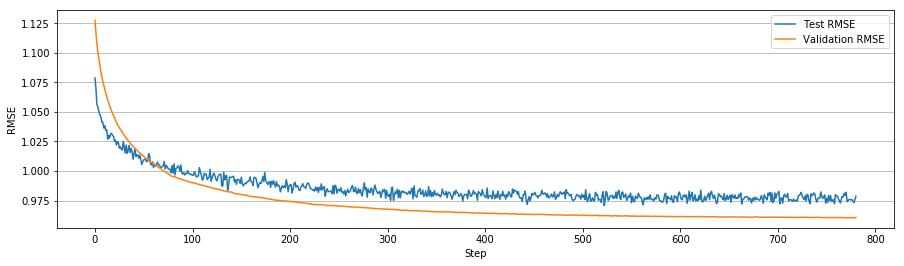

In [24]:
# Display training and validation error

_, t_values = list(map(np.asarray, zip(*training_values)))
_, v_values = list(map(np.asarray, zip(*validation_values)))

figure = plt.figure(figsize=(15, 4))
plt.plot(average(t_values, 64))
plt.plot(average(v_values, 64))
plt.grid(axis='y')
plt.legend(["Test RMSE", "Validation RMSE"])
plt.xlabel("Step")
plt.ylabel('RMSE');